In [1]:
import xarray as xr
import numpy as np
import matplotlib.colors as colors
from xarray import Dataset
import matplotlib.pyplot as plt

## Regridding

In [2]:
def regrid_bedmachine_to_bisicles_1km(ds: Dataset) -> Dataset:

    '''
    BedMachine comes on a 500m grid centered at 0,0. We want a BISICLES grid with resolution 1km,
    dimensions 6144 x 6144, and 0,0 in the bottom left corner. This function crops the BedMachine 
    data to the correct size and then coarsens it by a factor of 2 to achieve the correct resolution.

    All other datasets can be regridded to BISICLES by first interpolating to the BedMachine grid
    and then using this function.

    Parameters
    ----------
    da : DataArray
        The DataArray to be regridded
    size : int
        The size of the output grid (x and y)
    resolution : int
        The resolution of the output grid in metres
    '''

    N = 13333               # BedMachine grid size
    M = 6144                # BISICLES grid size
    factor = 1000 // 500     # coarsening factor
    
    lb = int((N+1 - M*factor) / 2) # lower bound
    ub = int((N+1 + M*factor) / 2) # upper bound

    # BedMachine comes with y coords going from +ve to -ve. I'm not sure if this is an issue for
    # BISICLES, but it's easier to work with if we flip it. The x coords are already in the right order.
    ds = ds.isel(y=slice(None, None, -1)) # flip y-axis
    
    cropped = ds.isel(x=slice(lb, ub), y=slice(lb, ub))
    coarse = cropped.coarsen(x=factor, y=factor).mean()

    coords = np.arange(500, 6.144e6, 1e3)
    bisicles = coarse.assign_coords(x=coords, y=coords)
    
    return bisicles

In [3]:
# Load the MEaSUREs dataset
measures = xr.open_dataset('/Users/jonniebarnsley/data/MEaSUREs/MEaSUREs_antarctica_ice_velocity_v2_450m.nc')
measures

<xarray.Dataset>
Dimensions:       (x: 12445, y: 12445)
Coordinates:
  * x             (x) float64 -2.8e+06 -2.8e+06 -2.799e+06 ... 2.799e+06 2.8e+06
  * y             (y) float64 2.8e+06 2.8e+06 2.799e+06 ... -2.799e+06 -2.8e+06
    lat           (y, x) float64 ...
    lon           (y, x) float64 ...
Data variables:
    coord_system  |S1 ...
    VX            (y, x) float32 ...
    VY            (y, x) float32 ...
    STDX          (y, x) float32 ...
    STDY          (y, x) float32 ...
    ERRX          (y, x) float32 ...
    ERRY          (y, x) float32 ...
    CNT           (y, x) int32 ...
Attributes: (12/26)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        vel_nsidc.CF16.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    spatial_resolution:        450m
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs
    creator_name:              J. Mouginot
    license:                   No restrictions on access or use

In [4]:
# Load the BedMachine dataset
bedmachine = xr.open_dataset('/Users/jonniebarnsley/data/BedMachine/BedMachineAntarctica-v3.nc')
bedmachine

<xarray.Dataset>
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
Data variables:
    mapping    |S1 ...
    mask       (y, x) int8 ...
    firn       (y, x) float32 ...
    surface    (y, x) float32 ...
    thickness  (y, x) float32 ...
    bed        (y, x) float32 ...
    errbed     (y, x) float32 ...
    source     (y, x) int8 ...
    dataid     (y, x) int8 ...
    geoid      (y, x) int16 ...
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

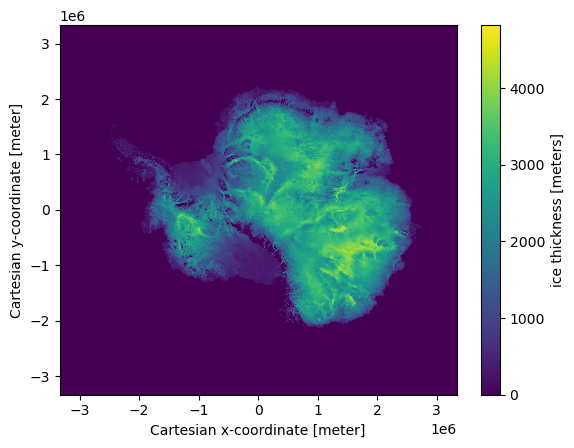

In [5]:
bedmachine.thickness.plot()

In [48]:
# Interpolate MEaSUREs data onto the BedMachine grid
measures_on_bedmachine = measures.interp(x=bedmachine.x, y=bedmachine.y, method='linear')
measures_on_bedmachine

<xarray.Dataset>
Dimensions:       (y: 13333, x: 13333)
Coordinates:
    lat           (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    lon           (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
  * x             (x) int32 -3333000 -3332500 -3332000 ... 3332500 3333000
  * y             (y) int32 3333000 3332500 3332000 ... -3332500 -3333000
Data variables:
    coord_system  |S1 b''
    VX            (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    VY            (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    STDX          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    STDY          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    ERRX          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    ERRY          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    CNT           (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/26)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        vel_nsidc.CF16.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    spatial_resolution:        450m
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs
    creator_name:              J. Mouginot
    license:                   No restrictions on access or use

In [49]:
# load a random BISICLES dataset – we want to manipulate our data onto this grid
bisicles = xr.open_dataset('/Users/jonniebarnsley/Downloads/antarctica_bedmachine_inverse_1km.nc')
bisicles

<xarray.Dataset>
Dimensions:  (x: 6144, y: 6144)
Coordinates:
  * x        (x) float64 500.0 1.5e+03 2.5e+03 ... 6.142e+06 6.142e+06 6.144e+06
  * y        (y) float64 500.0 1.5e+03 2.5e+03 ... 6.142e+06 6.142e+06 6.144e+06
Data variables:
    crs      int32 ...
    umod     (y, x) float64 ...
    umodc    (y, x) float64 ...
    btrc     (y, x) float64 ...
    velx     (y, x) float64 ...
    vely     (y, x) float64 ...
Attributes: (12/14)
    Conventions:         CF-1.7
    component_0:         umod
    component_1:         umodc
    component_2:         btrc
    component_3:         velx
    component_4:         vely
    ...                  ...
    num_components:      5
    num_levels:          1
    crs_origin_x:        0.0
    crs_origin_y:        0.0
    dx:                  1000.0
    Conversion_history:  slc removed this feature to see if it was causing chaos

In [50]:
# need to first crop and then coarsen the BedMachine data to align with the BISICLES grid.
# The function defined at the start of this notebook does this. 
bedmachine_on_bisicles = regrid_bedmachine_to_bisicles_1km(bedmachine)
measures_on_bisicles = regrid_bedmachine_to_bisicles_1km(measures_on_bedmachine)

In [9]:
# We can simplify the MEaSUREs data a bit. We only need speed for the inversion, not velocities.
# We also want to define a confidence function that takes values between 0 and 1, where 0 represents
# no confidence in the velocity observations and 1 represents full confidence. We try two alternative
# approaches to this:
#     1. Confidence is 1 where we have observations and 0 where we don't
#     2. Calculated confidence as a function of the velocity, standard deviation, and error

stdx = measures_on_bisicles.STDX
stdy = measures_on_bisicles.STDY
errx = measures_on_bisicles.ERRX
erry = measures_on_bisicles.ERRY
VX = measures_on_bisicles.VX
VY = measures_on_bisicles.VY

In [51]:
# Turn vector quantities into scalars
spd = np.sqrt(VX**2 + VY**2)
std = np.sqrt((VX**2 * stdx**2 + VY**2 * stdy**2)) / spd
err = np.sqrt((VX**2 * errx**2 + VY**2 * erry**2)) / spd
spd_nonull = spd.where(spd > 0, 0) # set negative values to 0

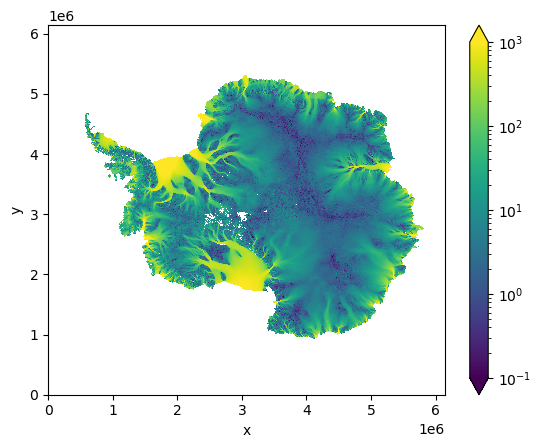

In [19]:
spd.plot(norm=colors.LogNorm(vmin=1e-1, vmax=1e3), cmap='viridis')

In [11]:
not_null = spd.notnull().astype(int) # confidence mask – 1 where speed obs exist, 0 where they don't

# in addition, we would like low confidence in areas of slow-moving ice (< 1 m/a) and thin ice (< 10 m)
thin_ice = bedmachine_on_bisicles.thickness < 10
slow_ice = spd < 1

# We can combine these two masks to create a new confidence mask
not_slow_or_thin = not_null.where(~(thin_ice | slow_ice), 0)

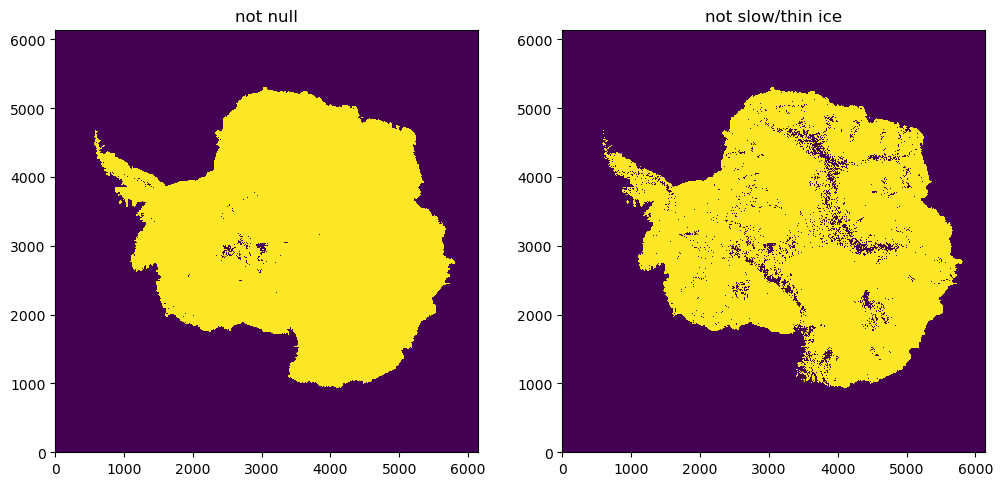

In [32]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax[0].pcolormesh(not_null)
ax[1].pcolormesh(not_slow_or_thin)
ax[0].set_title('not null')
ax[1].set_title('not slow/thin ice')

for x in ax:
    x.set_aspect('equal')

We can also consider confidence fields that take into account the variance and error of the velocity observations. One intuitive way to incorporate these is with the signal to noise ratio.

$$ \frac{\sqrt{\sigma^2 + \epsilon^2}}{|v|} $$

In [ ]:
signal_to_noise = np.sqrt(std**2 + err**2) / abs(spd) # signal to noise ratio (actually noise to signal ratio but who's counting)

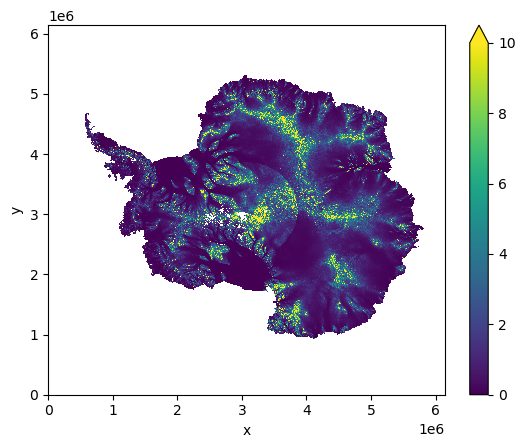

In [ ]:
signal_to_noise.plot(vmax=100, vmin=0)

In [ ]:
# save measures to file
ds = xr.Dataset(
    data_vars={
        'speed'             : (['x', 'y'], spd_nonull.data, {'units': 'm/yr', 'long_name': 'ice speed'}),
        'std'               : (['x', 'y'], std.data, {'units': 'm/yr', 'long_name': 'speed standard deviation'}),
        'err'               : (['x', 'y'], err.data, {'units': 'm/yr', 'long_name': 'speed error'}),
        'not_null'          : (['x', 'y'], not_null.data, {'description': 'confidence level. 1 where speed obs exist, 0 where they do not'}),
        'not_slow_or_thin'  : (['x', 'y'], not_slow_or_thin.data, {'description': 'confidence level. 0 where speed is less than 1 m/a or thickness is less than 10 m, otherwise 1'}),
        'signal_to_noise'   : (['x', 'y'], stn.data, {'description': 'alternative confidence level based on signal to noise ratio'})
    },
    coords={
        'x': measures_on_bisicles.x,
        'y': measures_on_bisicles.y
    },
    attrs={
        'title': 'MEaSUREs Antarctica Ice Velocity Data v2 on the BISICLES 1km Grid',
        'description': 'MEaSUREs ice velocity means, standard deviations, and errors have been combined into equivalent measurements for speed and regridded onto the BISICLES 1km grid.',
        'source': 'https://nsidc.org/data/nsidc-0484/versions/2'
    }
)
ds.to_netcdf('/Users/jonniebarnsley/data/MEaSUREs/MEaSUREs_antarctica_v2_bisicles_1km.nc')

In [ ]:
# save bedmachine to file
bedmachine_on_bisicles.to_netcdf('/Users/jonniebarnsley/data/BedMachine/BedMachine_antarctica_v3_bisicles_1km.nc')

/var/folders/d9/3tqzv4xj1sx00nng1hd597500000gn/T/ipykernel_3060/917460828.py:2: SerializationWarning: saving variable mask with floating point data as an integer dtype without any _FillValue to use for NaNs
  bedmachine_on_bisicles.to_netcdf('/Users/jonniebarnsley/data/BedMachine/BedMachine_antarctica_v3_bisicles_1km.nc')
/var/folders/d9/3tqzv4xj1sx00nng1hd597500000gn/T/ipykernel_3060/917460828.py:2: SerializationWarning: saving variable source with floating point data as an integer dtype without any _FillValue to use for NaNs
  bedmachine_on_bisicles.to_netcdf('/Users/jonniebarnsley/data/BedMachine/BedMachine_antarctica_v3_bisicles_1km.nc')
/var/folders/d9/3tqzv4xj1sx00nng1hd597500000gn/T/ipykernel_3060/917460828.py:2: SerializationWarning: saving variable dataid with floating point data as an integer dtype without any _FillValue to use for NaNs
  bedmachine_on_bisicles.to_netcdf('/Users/jonniebarnsley/data/BedMachine/BedMachine_antarctica_v3_bisicles_1km.nc')
/var/folders/d9/3tqzv4xj

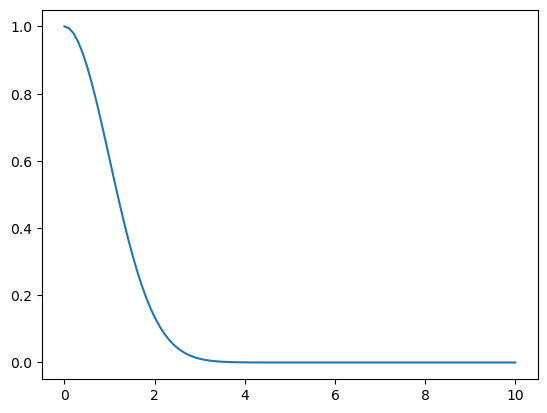

In [ ]:
# consider a function that transforms the signal to noise ratio onto the interval (0, 1)
def confidence(x, prefactor=0.5):
    return np.exp(-prefactor*x**2)

xvals = np.linspace(0, 10, 100)
yvals = confidence(xvals)
plt.plot(xvals, yvals)

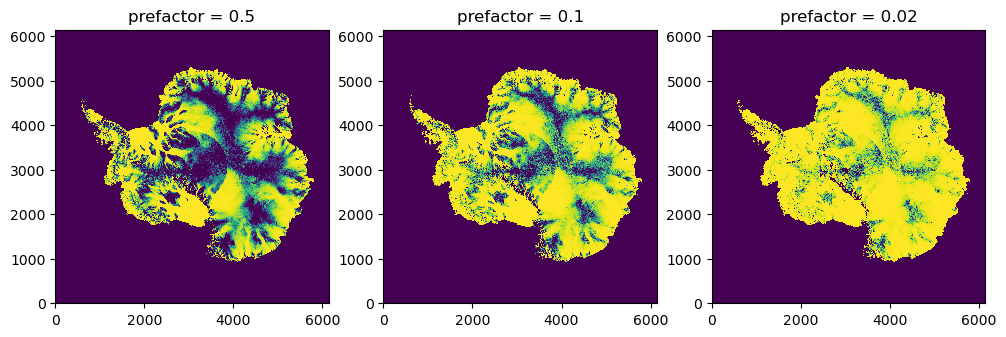

In [30]:
# test signal to noise transformed onto (0, 1) with different prefactors
cnf_05 = confidence(signal_to_noise, prefactor=0.5)
cnf_01 = confidence(signal_to_noise, prefactor=0.1)
cnf_002 = confidence(signal_to_noise, prefactor=0.02)

# set confidence equal to zero in areas with thin ice or no observations 
cnf_05 = cnf_05.where(~thin_ice & cnf_05.notnull(), 0)
cnf_01 = cnf_01.where(~thin_ice & cnf_01.notnull(), 0)
cnf_002 = cnf_002.where(~thin_ice & cnf_002.notnull(), 0)

fig, ax = plt.subplots(ncols=3, figsize=(12, 6))
ax[0].pcolormesh(cnf_05)
ax[1].pcolormesh(cnf_01)
ax[2].pcolormesh(cnf_002)
ax[0].set_title('prefactor = 0.5')
ax[1].set_title('prefactor = 0.1')
ax[2].set_title('prefactor = 0.02')
for x in ax:
    x.set_aspect('equal')

In [52]:
# save measures to file
ds = xr.Dataset(
    data_vars={
        'speed'     : (['x', 'y'], spd_nonull.data, {'units': 'm/yr', 'long_name': 'ice speed'}),
        'std'       : (['x', 'y'], std.data, {'units': 'm/yr', 'long_name': 'speed standard deviation'}),
        'err'       : (['x', 'y'], err.data, {'units': 'm/yr', 'long_name': 'speed error'}),
        'notnull'   : (['x', 'y'], not_null.data, {'description': 'basic confidence level. 1 where speed obs exist, 0 where they do not'}),
        'not_slow_or_thin': (['x', 'y'], not_slow_or_thin.data, {'description': 'confidence level. 0 where speed is less than 1 m/a or thickness is less than 10 m, otherwise 1'}),
        'prefactor_05'    : (['x', 'y'], cnf_05.data, {'description': 'alternative confidence level based on signal to noise ratio. Square-exponential transform with prefactor 0.5'}),
        'prefactor_01'    : (['x', 'y'], cnf_01.data, {'description': 'alternative confidence level based on signal to noise ratio. Square-exponential transform with prefactor 0.1'}),
        'prefactor_002'   : (['x', 'y'], cnf_002.data, {'description': 'alternative confidence level based on signal to noise ratio. Square-exponential transform with prefactor 0.02'}),
    },
    coords={
        'x': measures_on_bisicles.x,
        'y': measures_on_bisicles.y
    },
    attrs={
        'title': 'MEaSUREs Antarctica Ice Velocity Data v2 on the BISICLES 1km Grid',
        'description': 'MEaSUREs ice velocity means, standard deviations, and errors have been combined into equivalent measurements for speed and regridded onto the BISICLES 1km grid.',
        'source': 'https://nsidc.org/data/nsidc-0484/versions/2'
    }
)
ds.to_netcdf('/Users/jonniebarnsley/data/MEaSUREs/MEaSUREs_antarctica_v2_bisicles_1km.nc')

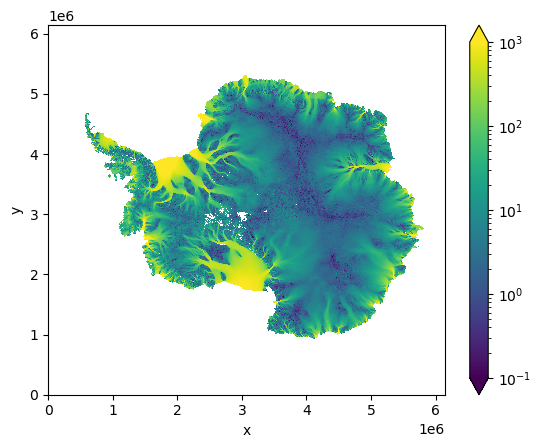

In [40]:
spd.plot(norm=colors.LogNorm(vmin=1e-1, vmax=1e3), cmap='viridis')

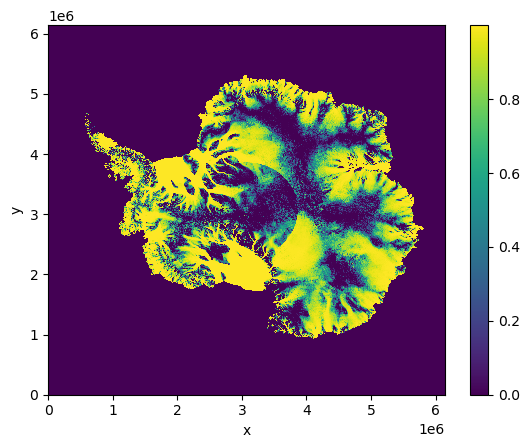

In [36]:
cnf_05.plot()

False

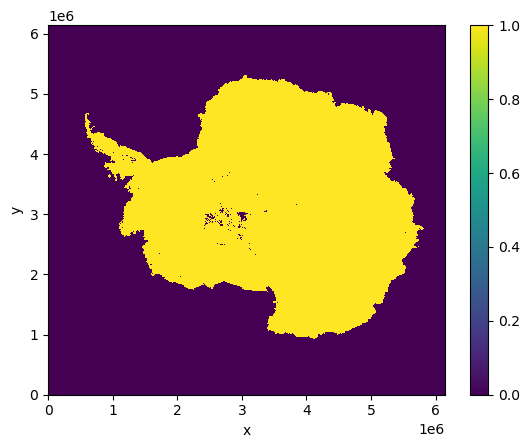

In [38]:
not(spd.notnull()).plot()